In [1]:
%matplotlib widget

from collections import deque

from solution import DIRECTION_VECTORS
from solution import Contestant
from solution import ContestantState
from solution import Coord
from solution import Direction
from solution import Entity
from solution import EntityKind
from solution import GameState
from solution import Node
from solution import Strategy


# For testing with Jupyter
def read_game_state_from_file(path: str) -> tuple[int, int, GameState]:
    # Read entities and cache by uid without refrence to root or parent
    with open(path, "r") as buffer:
        width, height = [int(i) for i in buffer.readline().strip().split()]

        tmp_entities: dict[
            int, tuple[Entity, int | None, int | None]
        ] = {}  # uid: (entity, parent_uid, root_uid)
        for idx in range(int(buffer.readline().strip())):
            (
                _x,
                _y,
                _kind,
                _owner,
                _uid,
                _dir,
                _parent_uid,
                _root_uid,
            ) = buffer.readline().strip().split()

            _tmp_uid = int(_uid) if int(_uid) else (-idx)
            tmp_entities[_tmp_uid] = (
                Entity(
                    uid=_tmp_uid,
                    x=int(_x),
                    y=int(_y),
                    kind=EntityKind(_kind),
                    owner=None if _owner == "-1" else Contestant(_owner),
                    direction=Direction(_dir),
                    root=None,
                    parent=None,
                ),
                None if int(_parent_uid) == -1 else int(_parent_uid),
                None if int(_root_uid) == -1 else int(_root_uid),
            )

        # Process entities
        entities: dict[Coord, Entity] = {}
        roots: dict[Contestant, Entity] = {}

        for entity, parent_uid, root_uid in tmp_entities.values():
            if parent_uid:
                entity = entity.update_parent(tmp_entities[parent_uid][0])
            if root_uid:
                entity = entity.update_root(tmp_entities[root_uid][0])

            entities[entity.coord] = entity
            if entity.kind == EntityKind.ROOT and entity.owner:
                roots[entity.owner] = entity

        my_a, my_b, my_c, my_d = [int(i) for i in buffer.readline().strip().split()]
        player_state = ContestantState(
            root=roots[Contestant.PLAYER],
            protein_a=my_a,
            protein_b=my_b,
            protein_c=my_c,
            protein_d=my_d,
        )

        opp_a, opp_b, opp_c, opp_d = [int(i) for i in buffer.readline().strip().split()]
        opponent_state = ContestantState(
            root=roots[Contestant.OPPONENT],
            protein_a=opp_a,
            protein_b=opp_b,
            protein_c=opp_c,
            protein_d=opp_d,
        )

        required_actions_count = int(buffer.readline().strip())

        return (
            width,
            height,
            GameState(
                player=player_state,
                opponent=opponent_state,
                entities=entities,
                actions=required_actions_count,
            ),
        )


width, height, game_state = read_game_state_from_file("./inputs/wood_3.txt")
entities, player, opponent = game_state.entities, game_state.player, game_state.opponent


In [2]:
""" Step 1: build graph from the player root """
nodes: dict[Coord, Node] = {
    # Initialize with the root node
    player.root.coord: Node(x=player.root.x, y=player.root.y, entity=player.root)
}
unvisited_coords: deque[Coord] = deque([player.root.coord])
visited_coords: set[Coord] = set()

while unvisited_coords:
    coord = unvisited_coords.popleft()
    if coord in visited_coords:
        continue

    x, y = coord
    node = nodes[coord]

    for direction, (i, j) in DIRECTION_VECTORS.items():
        c_x, c_y = coord[0] + i, coord[1] + j
        c_coord = (c_x, c_y)
        c_entity = entities.get(c_coord)

        if any(
            (
                c_x < 0 or c_x >= width,
                c_y < 0 or c_y >= height,
                c_entity and c_entity.kind == EntityKind.WALL,
            )
        ):
            continue

        if c_coord not in nodes:
            c_node = Node(x=c_x, y=c_y, entity=c_entity, parent=node)
            node.children.add(c_node)
            nodes[c_coord] = c_node

            # Determine strategies to get to child
            if not node.entity:
                # Append the default strategy
                node.strategies.add(
                    Strategy.for_entity_kind(
                        source=node, target=c_node, kind=EntityKind.BASIC
                    )
                )

                if c_entity:
                    if c_entity.kind in EntityKind.PROTEINS:
                        node.strategies.add(
                            Strategy.for_entity_kind(
                                source=node,
                                target=c_node,
                                kind=EntityKind.HARVESTER,
                                direction=direction,
                            )
                        )
                    elif (
                        c_entity.kind in EntityKind.ORGANISMS
                        and c_entity.owner
                        and c_entity.owner == Contestant.OPPONENT
                    ):
                        node.strategies.add(
                            Strategy.for_entity_kind(
                                source=node,
                                target=c_node,
                                kind=EntityKind.TENTACLE,
                                direction=direction,
                            )
                        )

            unvisited_coords.append(c_coord)

    visited_coords.add(coord)


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['orange', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightorange', 'lightorange', 'lightblue', 'lightorange', 'blue', 'blue', 'lightorange', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'lightgray', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']

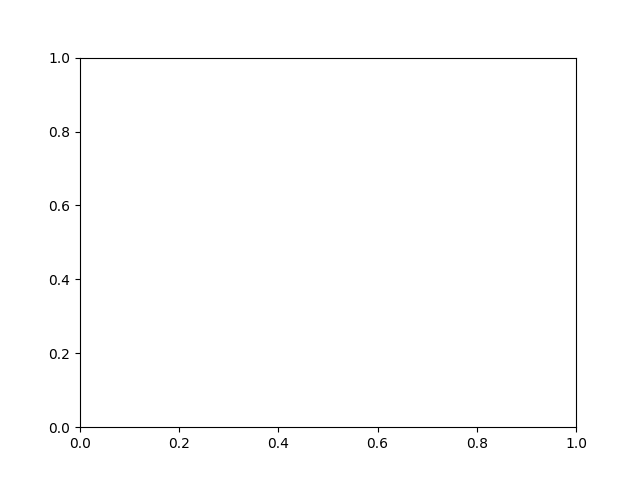

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from zmq import has

G = nx.DiGraph()

for node in nodes.values():
    for child in node.children:
        G.add_edge(node, child)

colormap = []
for node in G:
    if node.entity and node.entity.owner == Contestant.PLAYER:
        colormap.append("orange")
    elif node.entity and node.entity.owner == Contestant.OPPONENT:
        colormap.append("blue")
    elif node.strategies:
        has_harvester, has_tentacle = False, False
        for strategy in node.strategies:
            if strategy.kind == EntityKind.HARVESTER:
                has_harvester = True
            elif strategy.kind == EntityKind.TENTACLE:
                has_tentacle = True
        if has_harvester:
            colormap.append("lightgreen")
        elif has_tentacle:
            colormap.append("navajowhite")
        else:
            colormap.append("lightblue")

    else:
        colormap.append("lightgray")

pos = {node: node.coord for node in nodes.values()}


# add axis
fig, ax = plt.subplots()
nx.draw_networkx(
    G,
    arrows=True,
    pos=pos,
    node_size=100,
    ax=ax,
    node_color=colormap,
    width=1,
    arrowstyle="-|>",
    arrowsize=8,
    with_labels=False,
)  # draw nodes and edges
plt.axis("on")
ax.set_xlim(0, width - 1)
ax.set_ylim(height - 1, 0)
ax.set_aspect("equal")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()